In [13]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from RC_Plane_v3 import RCPlane
import pygad

## Mission Scoring Functions

In [14]:
def round_inches(x: float) -> float:
    """
    Round a measurement in inches down to the nearest 0.00, 0.25, 0.50, or 0.75.

    Example:
        10.37 -> 10.25
        5.81  -> 5.75
        7.99  -> 7.75
    """
    # Whole inch part
    whole = int(x)

    # Fractional part
    frac = x - whole

    # Define breakpoints
    targets = [0.00, 0.25, 0.50, 0.75]

    # Find the largest target <= frac
    rounded_frac = max([t for t in targets if t <= frac], default=0.00)

    return whole + rounded_frac

def mission_2(num_passengers, num_cargo, m2_laps, battery_capacity):

    income = (num_passengers * (6 + 2 * m2_laps)) + (num_cargo * (10 + 8 * m2_laps))
    EF = battery_capacity / 100
    cost = m2_laps * (10 + (num_passengers*0.5) + (num_cargo*2)) * EF
    net_income = income - cost
    m2 = 1 + (net_income / 900)
    return m2

def mission_3(banner_length, number_of_laps, wing_span):
    """
    :param banner_length: length in inches
    :param number_of_laps: number of laps
    :param wing_span: span in metres
    :return: mission 3 score with best score of 410
    """
    wing_span_inches = wing_span * 39.3701
    pre = round(wing_span_inches)/12 * 0.05 + 0.75
    RAC = pre if pre >= 0.9 else 0.9
    rounded_banner = round_inches(banner_length)
    m3 = (rounded_banner * number_of_laps / RAC)
    m3_best = 1100
    return 2 + (m3 / m3_best)

def mission_2raw(num_passengers, num_cargo, m2_laps, battery_capacity):

    income = (num_passengers * (6 + 2 * m2_laps)) + (num_cargo * (10 + 8 * m2_laps))
    EF = battery_capacity / 100
    cost = m2_laps * (10 + (num_passengers*0.5) + (num_cargo*2)) * EF
    net_income = income - cost
    return net_income
def mission_3raw(banner_length, number_of_laps, wing_span):
    """
    :param banner_length: length in inches
    :param number_of_laps: number of laps
    :param wing_span: span in metres
    :return: mission 3 score with best score of 410
    """
    wing_span_inches = wing_span * 39.3701
    pre = round(wing_span_inches)/12 * 0.05 + 0.75
    RAC = pre if pre >= 0.9 else 0.9
    rounded_banner = round_inches(banner_length)
    m3 = (rounded_banner * number_of_laps / RAC)
    return m3

## Combined Mission Objective Function

In [40]:
def objective_total(x):
    """
    Calculates the combined (negative) score for Mission 2 and Mission 3.

    Args:
        x (tuple/array): Decision variables (m_struct, wing_span, motor_power, wing_AR, n_pucks, 
            passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery).
    """
    # Unpack decision variables
    m_struct, wing_span, motor_power, wing_AR, n_pucks, passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery = x

    # Scoring
    try:
        plane = RCPlane(m_struct, wing_span, motor_power, wing_AR, n_pucks, passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery)
        
        m2_score = mission_2(plane.m2.num_ducks, plane.m2.num_pucks, plane.m2.num_laps, m2_battery)
        if not np.isfinite(m2_score):
            return -10
        
        m3_score = mission_3(banner_length, plane.m3.num_laps, wing_span)
        if not np.isfinite(m3_score):
            return -10
        
    except Exception as error:
        print(f"RCPlane Error: {error}")
        return -10
    
    # Final Objective (Minimizing negative score)
    final_score = (m3_score + m2_score)
    print()
    print(f"M2: {m2_score}\nM3: {m3_score}\nFINAL M2 + M3 SCORE: {final_score}")
    return (m3_score + m2_score)

## Genetic Algo

In [44]:
# 1. Define the Range and Type for each Parameter (Gene)
gene_space = [
    # m_struct (Real: 0.2 to 20)
    {'low': 0.2, 'high': 20},
    
    # wing_span (Real: 0.92 to 1.52)
    {'low': 0.92, 'high': 1.52},
    
    # motor_power (Integer: 40 to 4000)
    {'low': 40, 'high': 4000, 'step': 1},
    
    # wing_AR (Integer: 1 to 8)
    {'low': 1, 'high': 8, 'step': 1},
    
    # n_pucks (Integer: 1 to 30)
    {'low': 1, 'high': 30, 'step': 1},
    
    # passenger_cargo_ratio (Integer: 3 to 15)
    {'low': 3, 'high': 15, 'step': 1},
    
    # m2_battery (Integer/Real Wh: 1 to 100) - Treat as Real for fine search, or integer step
    {'low': 1, 'high': 100}, 
    
    # banner_length (Integer: 1 to 1000)
    {'low': 1, 'high': 1000, 'step': 1},
    
    # banner_AR (Integer: 1 to 5)
    {'low': 1, 'high': 5, 'step': 1},
    
    # m3_battery (Integer/Real Wh: 1 to 100)
    {'low': 1, 'high': 100}
]

def fitness_func(ga_instance, solution, solution_idx):
    fitness = objective_total(solution)
    return fitness

fitness_function = fitness_func

### Bayesian Optimisation for Genetic Algorithm Hyperparameters

In [0]:
#m_struct, wing_span, motor_power, wing_AR, n_pucks, passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery
search_space = [
    Real(0.2, 20, name="m_struct"), #kg
    Real(0.92, 1.52, name="wing_span"), # m
    Integer(40, 4000, name="motor_power"), #W
    Integer(1, 8, name="wing_AR"), 
    Integer(1, 30, name="pucks"),
    Integer(3, 15, name="passenger_cargo_ratio"),
    Integer(1, 100, name="m2_battery"), #Wh
    Integer(1, 1000, name="banner_length"), #inch
    Integer(1, 5, name="banner_AR"),
    Integer(1, 100, name="m3_battery") #Wh
]

# Run Bayesian Optimization
result = gp_minimize(
    objective_total,
    search_space,
    n_calls=100,
    n_initial_points=10,
    random_state=42
)

# Best design
best_params = result.x
#WS, pucks, PC_ratio, banner_length, banner_AR, m2_fly_time, m3_fly_time
print("Best parameters found:", best_params)

In [0]:
m_struct, wing_span, motor_power, wing_AR, n_pucks, passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery = best_params
plane = RCPlane(m_struct, wing_span, motor_power, wing_AR, n_pucks, passenger_cargo_ratio, m2_battery, banner_length, banner_AR, m3_battery)

print(plane)

In [75]:
# 3. Initialize PyGAD
ga_instance = pygad.GA(
    num_generations=250,             # Number of iterations
    num_parents_mating=20,          # Number of solutions to select as parents
    fitness_func=fitness_func,      # The function to maximize
    sol_per_pop=300,                 # Number of solutions in the population
    num_genes=10,                   # Total number of parameters
    gene_space=gene_space,          # <-- This tells PyGAD the bounds!
    mutation_type="random",
    mutation_percent_genes=10,      # Percentage of genes to mutate
    crossover_type="single_point",
    parent_selection_type="tournament",# Steady-State Selection
    K_tournament=3,
    keep_elitism=2,
    mutation_probability=0.05,
    crossover_probability=0.9
    # Additional settings for faster/better search
)

In [76]:
# 4. Run the optimization
ga_instance.run()

RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 

Test sol_per_pop 50, generation 500, best score is 5.17
Test sol_per_pop 100, generation 500, best score is 5.13
Test sol_per_pop 200, generation 500, best score is 5.5

In [77]:
# 5. Get the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()

RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Sized Mass deviates from Input Mass by too much
RCPlane Error: 3: N_max must be greater than 1

M2: 2.3037716360414957
M3: 2.755844155844156
FINAL M2 + M3 SCORE: 5.059615791885651
RCPlane Error: Number of Laps cannot be less than 1
Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1

M2: 2.096566164226044
M3: 2.755844155844156
FINAL M2 + M3 SCORE: 4.8524103200702005
Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1

M2: 2.364461659884724
M3: 2.755844155844156
FINAL M2 + M3 SCORE: 5.12030581572888
Error: 3: N_max must be greater than 1
RCPlane Error: 3: N_max must be greater than 1
RCPlane Error: Number of Laps cannot be less than 1
RCPlane Error: Number of Laps 

In [78]:
# Get the best inputs, ensuring integers are rounded and cast
best_params = solution
best_params[2] = int(round(best_params[2]))   # motor_power
best_params[3] = int(round(best_params[3]))   # wing_AR
best_params[4] = int(round(best_params[4]))   # n_pucks
best_params[5] = int(round(best_params[5]))   # P/C_ratio
best_params[7] = int(round(best_params[7]))   # banner_length
best_params[8] = int(round(best_params[8]))   # banner_AR

param_names = [
    "m_struct (kg)", "wing_span (m)", "motor_power (W)", "wing_AR", "n_pucks", 
    "P/C_ratio", "m2_battery (Wh)", "banner_length (in)", "banner_AR", "m3_battery (Wh)"
]

print(f"Best Fitness Score: {solution_fitness:.4f}")
print(f"Best Solution found (Gene Array): {best_params}")

# Display in a readable format
print("\n--- Best RCPlane Configuration ---")
# Define a consistent alignment width (e.g., 10 characters)
VALUE_WIDTH = 10 

for name, value in zip(param_names, best_params):
    # Use appropriate formatting based on parameter type
    
    # If the parameter is Real/Mass/Span, use 3 decimal places and right alignment
    if 'Real' in name or 'mass' in name or 'span' in name:
        format_str = f">{VALUE_WIDTH}.3f" # Example: >10.3f
    
    # If the parameter is Integer, use right alignment with no decimal
    else:
        format_str = f">{VALUE_WIDTH}" # Example: >10

    # Print the line using the fully constructed format string
    print(f"  {name:<25}: {value:{format_str}}")

# Optional: Run the best solution through the RCPlane class again to verify full performance metrics
# This step is good practice as the fitness function only returned the score.

final_plane = RCPlane(
    best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], 
    best_params[5], best_params[6], best_params[7], best_params[8], best_params[9]
)

print("\n--- Performance Check (M2 / M3) ---")
print(f"M2 Laps / V_cruise: {final_plane.m2.num_laps} / {final_plane.m2.V_cruise:.2f} m/s")
print(f"M3 Laps / V_cruise: {final_plane.m3.num_laps} / {final_plane.m3.V_cruise:.2f} m/s")

Best Fitness Score: 5.1293
Best Solution found (Gene Array): [8.08834479e-01 1.11241145e+00 1.13800000e+03 4.00000000e+00
 2.00000000e+01 6.00000000e+00 7.62450236e+01 3.88000000e+02
 4.00000000e+00 9.49255032e+01]

--- Best RCPlane Configuration ---
  m_struct (kg)            : 0.8088344792814921
  wing_span (m)            :      1.112
  motor_power (W)          :     1138.0
  wing_AR                  :        4.0
  n_pucks                  :       20.0
  P/C_ratio                :        6.0
  m2_battery (Wh)          : 76.24502364463002
  banner_length (in)       :      388.0
  banner_AR                :        4.0
  m3_battery (Wh)          : 94.92550318935

--- Performance Check (M2 / M3) ---
M2 Laps / V_cruise: 1.0 / 21.20 m/s
M3 Laps / V_cruise: 2.0 / 17.71 m/s


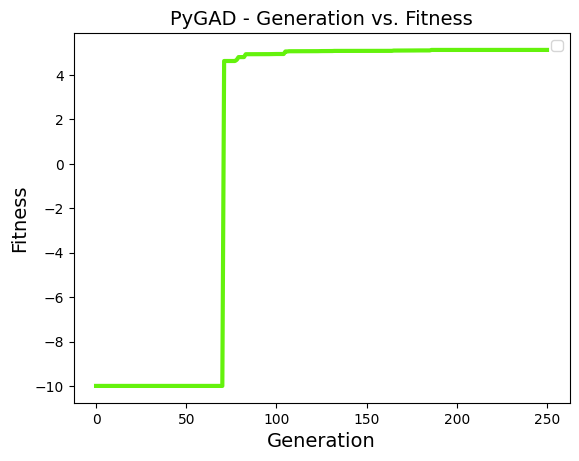

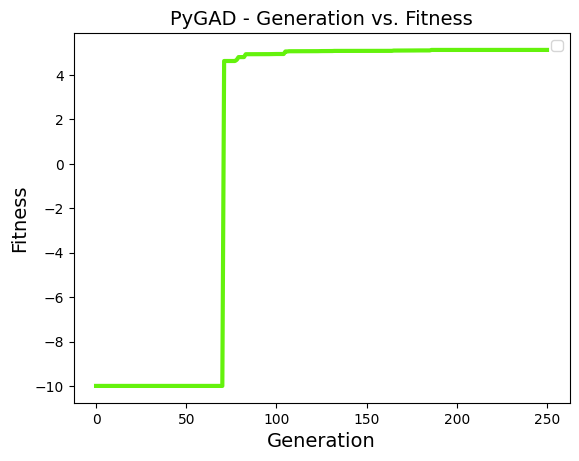

In [79]:
# Optional: Plot the fitness progression
ga_instance.plot_fitness()